### Oleksiy Anokhin (July 20, 2020)

### Starbucks App Customer Rewards Program (Initial Exploratory Data Analysis)

### MSCA 31008 | Data Mining Principles | Professor U. Pamuksuz | Team Project

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. 

Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

The task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You’ll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

We have been given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

This dataset is about offers sent during 30-day test period. There are totally 10 offers. 4 of them are BOGO, 4 are discount and 2 are informational. All offers are distributed via email. By contrast only 6 offers are showed in social networks.

A selected group receives offers for discounts (20% off when spending $10+), bogo (buy one, get one) or informational offers. Various offers differ in type, duration, difficulty (minimum spending) and reward (provided in discount). Also, there are some demographic data available.

The data is contained in three files:

portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)

profile.json - demographic data for each customer

transcript.json - records for transactions, offers received, offers viewed, and offers completed

Normally, offers have an offer received event, followed by offer viewed and offer completed. **There must be a transaction accompanying an offer completed event**. However, informational offers do not get an offer completed event, but are completed when viewed. And it is also possible that an offer is completed without being viewed. The offer has not affected the transaction in that case, and we should not mark them as completed.

**Each offer has a duration for which it remains valid.** We can check the response time by subtracting the time for the 'offer viewed' event from the time of the 'offer completed' event. It should not exceed the duration. 

Data Sets

The data is contained in three files:

- portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)

- profile.json - demographic data for each customer

- transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

**profile.json**
- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income

**transcript.json**

- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours since start of test. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from scipy import stats
from scipy import interpolate
import re
from sklearn.preprocessing import MultiLabelBinarizer

C:\Users\oleks\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Set additional parameters
# Remove column display limits
pd.set_option('display.max_columns', None)
# pd.set_option('display.height', None)
pd.set_option('display.max_rows', None)
# pd.set_option('display.width', None)
plt.rcParams['figure.figsize'] = [15, 10]
sns.set_style("white")

# Set a color palette
starbucks = ["#00704A", "#362415", "#eac784", "#604c4c"]
# https://www.color-hex.com/color-palette/8208
# But our green tone is different - #00704A

In [3]:
# Read json data
portfolio = pd.read_json('portfolio.json', orient = 'records', lines = True)
profile = pd.read_json('profile.json', orient = 'records', lines = True)
transcript = pd.read_json('transcript.json', orient = 'records', lines = True)

In [4]:
# View Portfolio data
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
# Dimensions
portfolio.shape

(10, 6)

In [6]:
# Read Profile data
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
# View Transcript data
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


#### 1. Exploratory Data Analysis

**1.1. Analyze profile of a customer, who received an offer**

In [8]:
# Analyze customers by year
# Remove days and months
profile.became_member_on = profile.became_member_on // 1
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


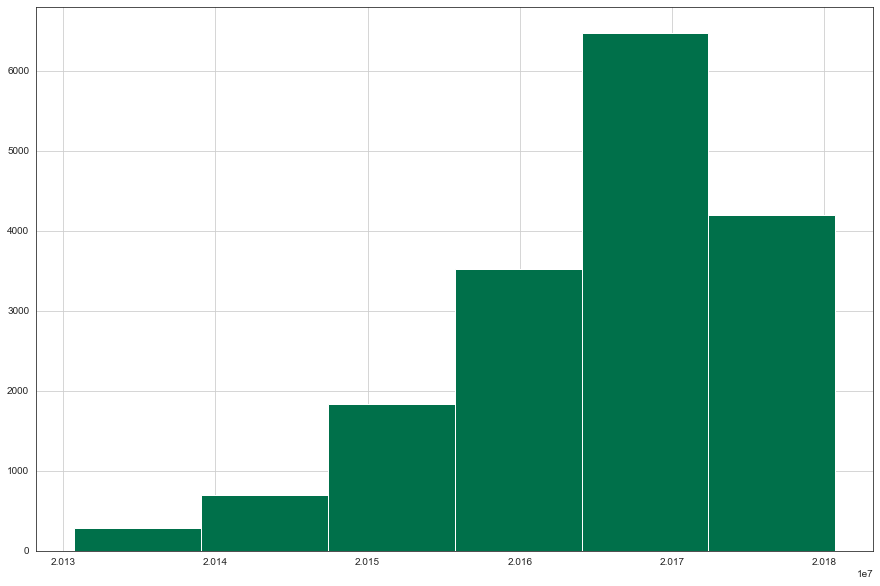

In [9]:
# Visualize by year
profile.became_member_on.hist(bins = 6, color = '#00704A')

In [10]:
profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

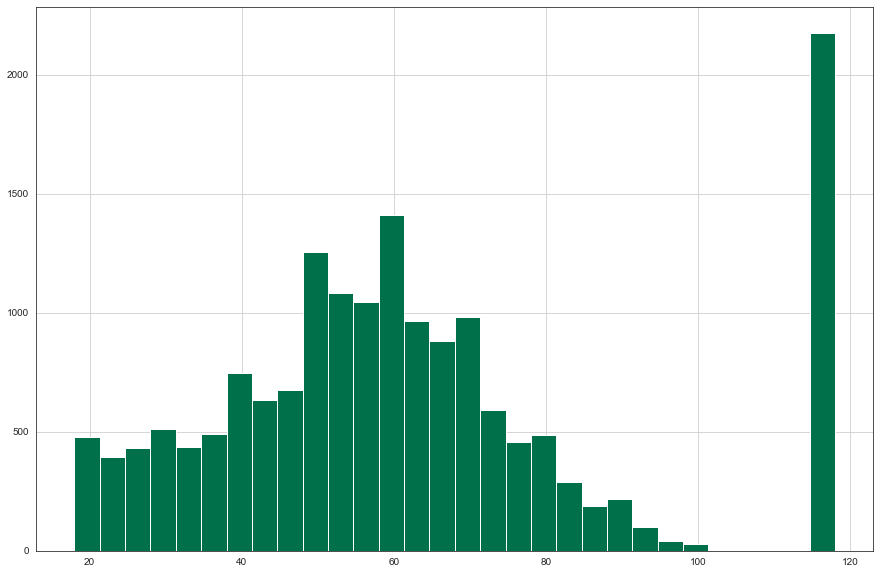

In [11]:
# Histogram of the age
profile.age.hist(bins = 30, color = '#00704A')

In [12]:
# Calculate values
profile.age.value_counts().head()
# Obvious typos here, some customers has age 118

118    2175
58      408
53      372
51      363
54      359
Name: age, dtype: int64

In [13]:
# Calculate the number of 118 values in age column
np.sum(profile.age == 118)
# Hence, we have 2175 people here

2175

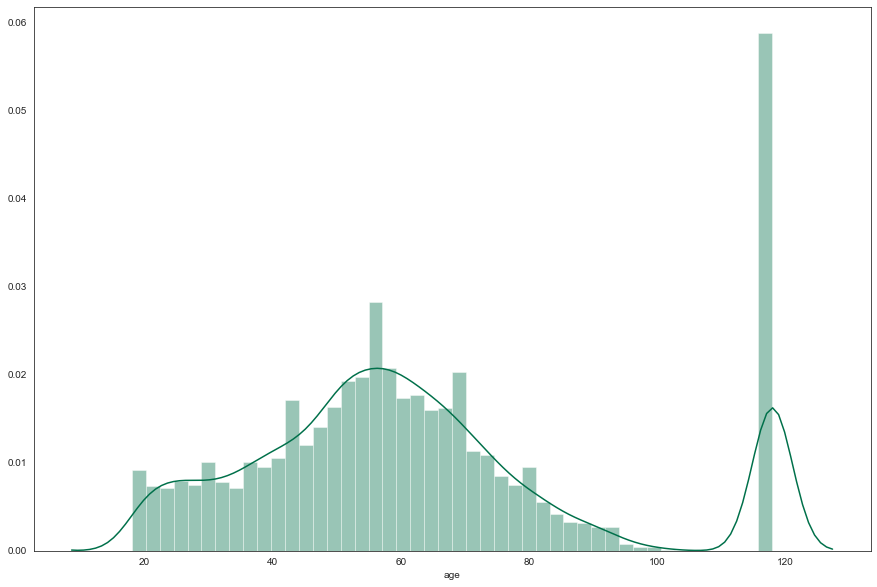

In [14]:
# Plot with line
sns.distplot(profile[profile['age'].notnull()]['age'], color = "#00704A")

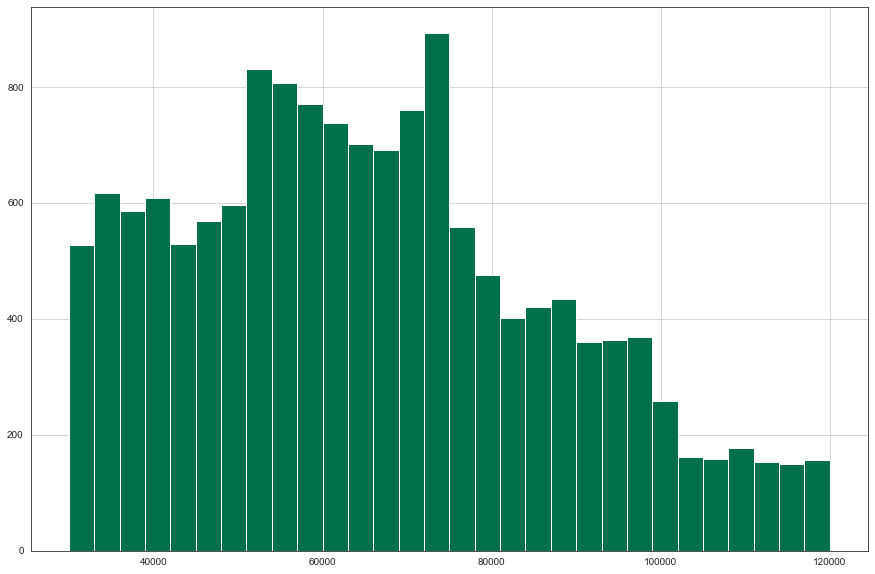

In [15]:
# Histogram of the age
profile.income.hist(bins = 30, color = '#00704A')

In [16]:
# Calculate values
profile.income.value_counts().head()
# There are NA values here too
# Our base is a group of people with income from 50000+ to 75000 dollars

73000.0    314
72000.0    297
71000.0    294
57000.0    288
74000.0    282
Name: income, dtype: int64

In [17]:
# Calculate the number of NA values in income column
profile.isnull().sum()
# Hence, we have 2175 people here too

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

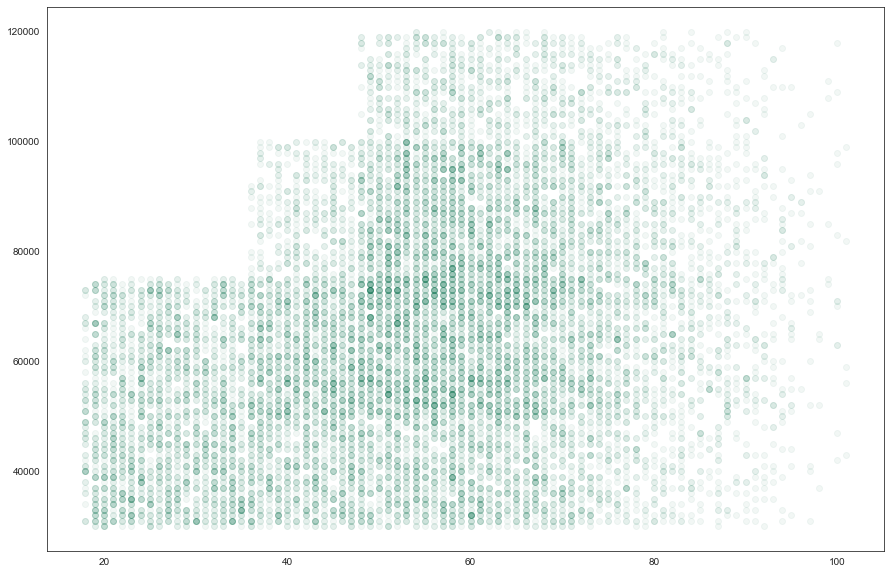

In [18]:
# Analyze the correlation between age and income
plt.scatter(profile.age, profile.income, alpha = 0.05, color = "#00704A")

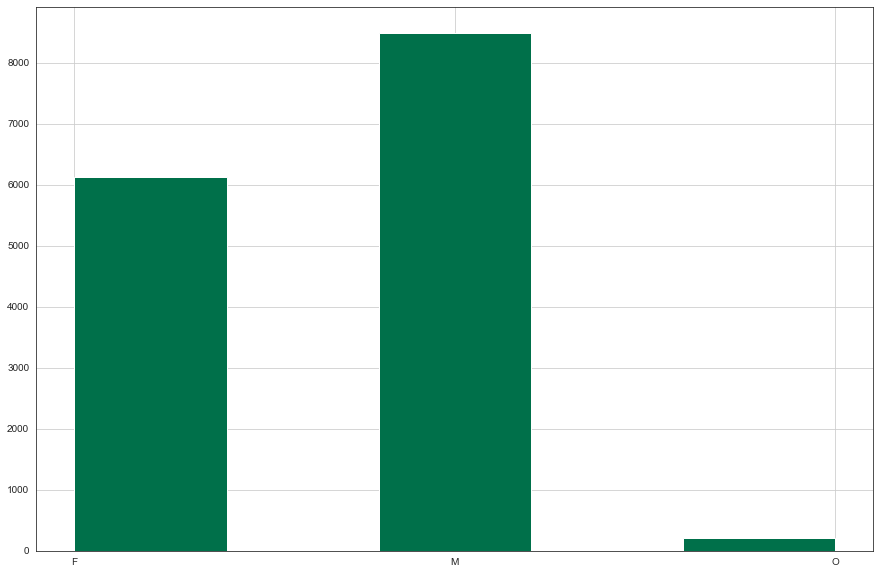

In [19]:
# Check customer gender
profile.gender.hist(bins = 5, color = '#00704A')

In [20]:
# Calculate values
profile.gender.value_counts()
# We can see that we have more than 6000 females, more than 8000 males, and some missing data

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [21]:
# Count values - 212 'O'
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Text(0.5, 1.0, 'Income distribution by gender')

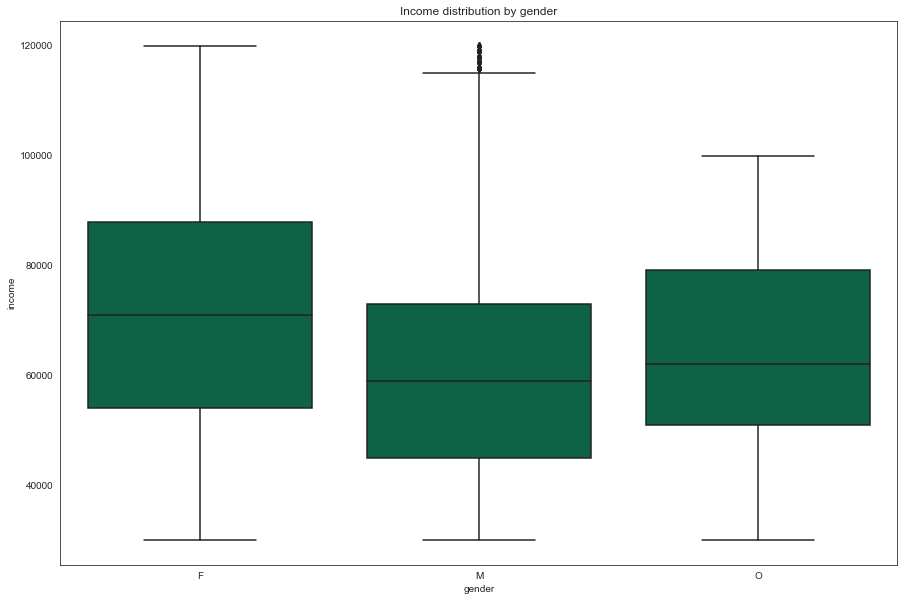

In [22]:
# Create a box plot of income by gender
sns.boxplot(profile['gender'], profile['income'], color = '#00704A')
plt.title("Income distribution by gender")
# As we can see, our female customers are significantly wealthier than their male counterparts

Text(0.5, 1.0, 'Age distribution by gender')

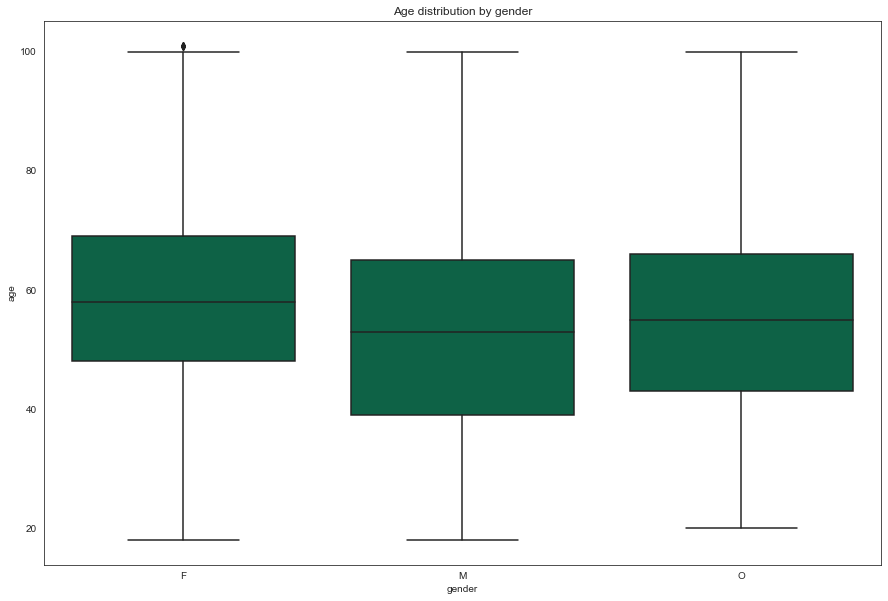

In [23]:
# Create a box plot of age by gender
sns.boxplot(profile['gender'], profile['age'], color = '#00704A')
plt.title("Age distribution by gender")
# The age distribution of our targeted customers is pretty similar. 
# It is interesting that our main audience - people between 40 and 70 years old. 

Text(0.5, 0.98, 'Age, income by gender')

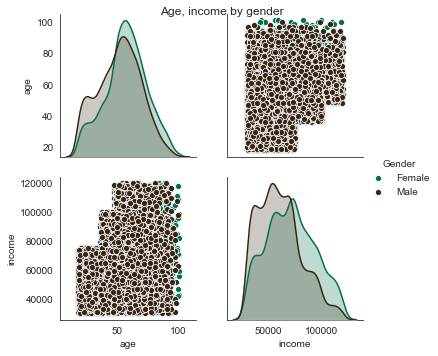

In [24]:
# Compare age and income by gender
sns.set_palette(sns.color_palette(starbucks))
df = profile[['gender', 'age', 'income']].query('gender in ["F", "M"]')
df.rename(columns={'gender': 'Gender'}, inplace = True)
df['Gender'] = df['Gender'].map({'M': 'Male', 'F': 'Female'})
g = sns.pairplot(df, hue = 'Gender')
g.fig.suptitle("Age, income by gender")

**1.2. Analyze the transcript of offers**

In [35]:
# View types of event (how did a customer react?)
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

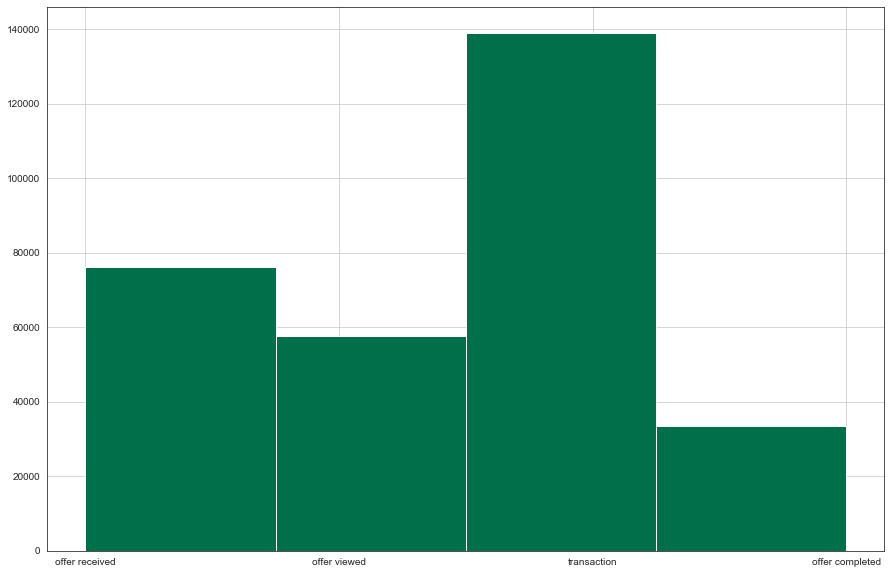

In [36]:
# Visualize the reaction of customers
transcript.event.hist(bins = 4, color = '#00704A')

In [37]:
# Calculate values
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

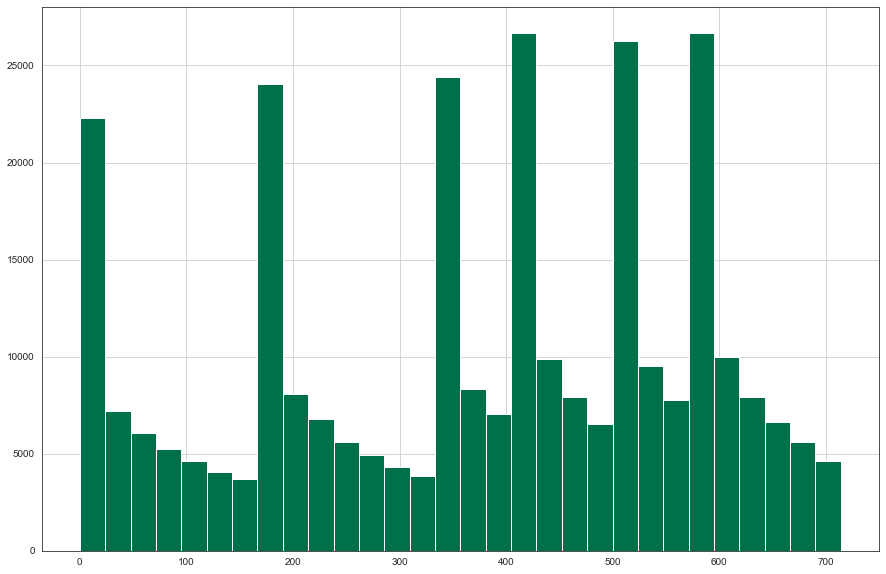

In [38]:
# Analyze the time of the offer
transcript.time.hist(bins = 30, color = '#00704A')

In [40]:
# Calculate values
transcript.time.value_counts().head()

408    17030
576    17015
504    16822
336    16302
168    16150
Name: time, dtype: int64

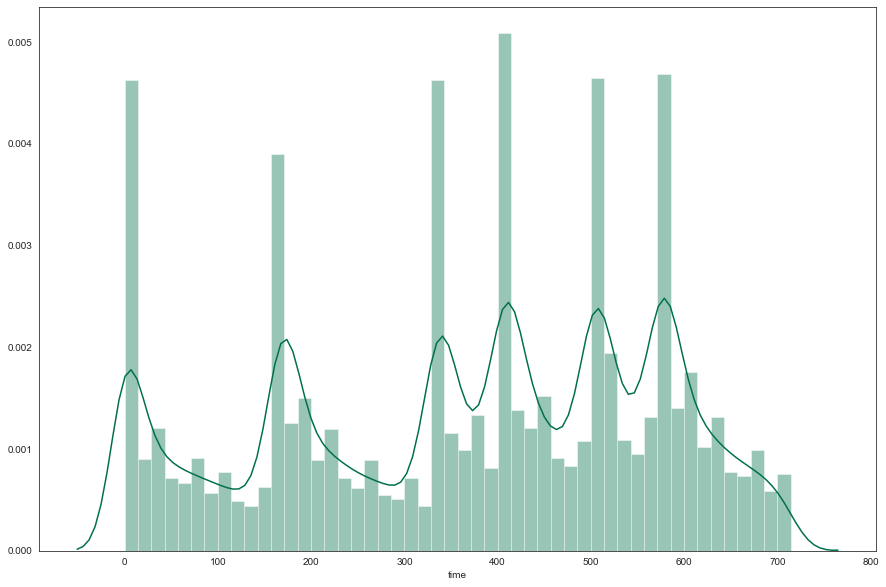

In [41]:
# Plot with line
sns.distplot(transcript[transcript['time'].notnull()]['time'], color = "#00704A")

In [42]:
# Check types of columns in Transcript
transcript.dtypes

person    object
event     object
value     object
time       int64
dtype: object

In [43]:
# Create a separate dataframe and clean the value column, leaving only the amount
transcript_value = pd.read_json('transcript.json', orient = 'records', lines = True)
transcript_value['value'] = transcript_value['value'].str.get('amount')
transcript_value.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,NaN,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,NaN,0
2,e2127556f4f64592b11af22de27a7932,offer received,NaN,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,NaN,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,NaN,0


[Text(0, 0, 'transaction'),
 Text(0, 0, 'offer received'),
 Text(0, 0, 'offer viewed'),
 Text(0, 0, 'offer completed')]

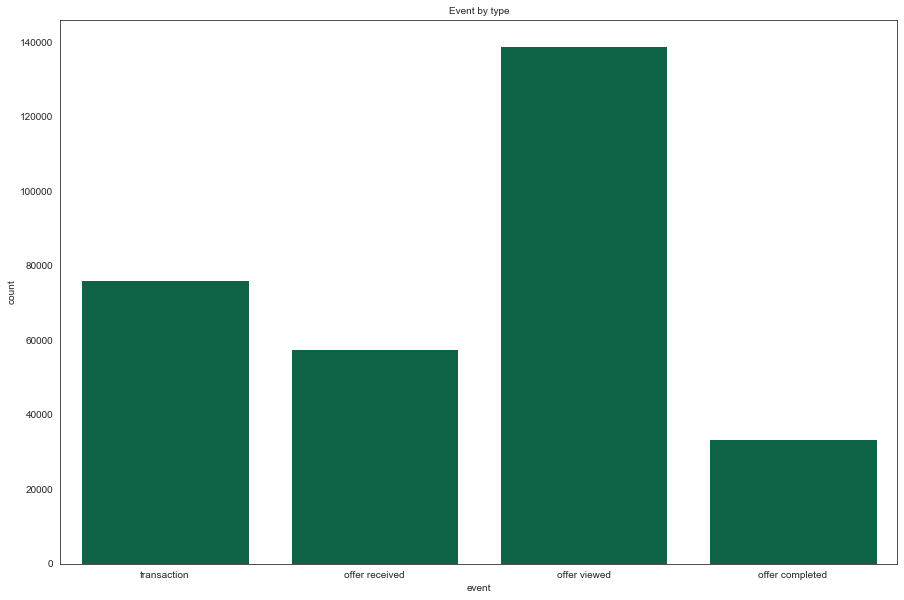

In [44]:
# Visualize by type
event_type = sns.countplot(transcript["event"], color = "#00704A")
event_type.set_title('Event by type', size = 10)
event_type.set_xticklabels(labels = ("transaction", "offer received", "offer viewed", "offer completed"))